# Necessary library import, data module, as well as the model

In [2]:
import os
import copy
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from torch import optim
import torch.nn.functional as F
import os
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

In [4]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

In [6]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

In [7]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

In [8]:
class UNet_conditional(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes=None, device=device):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2, device=self.device).float() / channels))
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t, y):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

In [9]:
class Diffusion:
    def __init__(self, noise_steps=1024, beta_start=1e-4, beta_end=0.02, img_size=256, device=device):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.device = device

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, labels, cfg_scale=3):
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

# Please uncomment to train the model from scratch

In [10]:
# transforms = torchvision.transforms.Compose([
#         torchvision.transforms.Resize(80),  # args.image_size + 1/4 *args.image_size
#         torchvision.transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
#         torchvision.transforms.ToTensor(),
#         torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])
# # use CIFAR10
# dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
# dataloader = DataLoader(dataset, batch_size=14, shuffle=True)

# os.makedirs("models", exist_ok=True)
# model = UNet_conditional(num_classes=10).to(device)
# #uncomment if want to load the previous training weight
# # model.load_state_dict(torch.load("models/ckpt.pt"))
# optimizer = optim.AdamW(model.parameters(), lr=3e-4)
# mse = nn.MSELoss()
# diffusion = Diffusion(img_size=32, device=device)
# l = len(dataloader)
# ema = EMA(0.995)
# ema_model = copy.deepcopy(model).eval().requires_grad_(False)
# #uncomment if want to load the previous training weight
# # ema_model.load_state_dict(torch.load("models/ema_ckpt.pt"))
# ema_model.to(device)


# epochs = 300

# for epoch in range(epochs):
#     pbar = tqdm(dataloader)
#     for i, (images, labels) in enumerate(pbar):
#         images = images.to(device)
#         labels = labels.to(device)
#         t = diffusion.sample_timesteps(images.shape[0]).to(device)
#         x_t, noise = diffusion.noise_images(images, t)
#         if np.random.random() < 0.1:
#             labels = None
#         predicted_noise = model(x_t, t, labels)
#         loss = mse(noise, predicted_noise)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         ema.step_ema(ema_model, model)

#         pbar.set_postfix(MSE=loss.item())

#     if epoch % 10 == 0:
#         #read the saved epoch
#         labels = torch.arange(10).long().to(device)
#         sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
#         ema_sampled_images = diffusion.sample(ema_model, n=len(labels), labels=labels)
#         plt.figure(figsize=(64, 64))
#         plt.imshow(torch.cat([torch.cat([i for i in images.cpu()], dim=-1),], dim=-2).permute(1, 2, 0).cpu())
#         plt.show()
#         torch.save(model.state_dict(), os.path.join("models", "ckpt.pt"))
#         torch.save(model.state_dict(), os.path.join("models", "ema_ckpt.pt"))

# To run the result with the pretrain model

In [11]:
n = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet_conditional(num_classes=10).to(device)
model.load_state_dict(torch.load("ckpt.pt"))
diffusion = Diffusion(img_size=64, device=device)

In [12]:
tag_dict = {"airplane":0, "auto":1, "bird":2, "cat":3, "deer":4, "dog":5, "frog":6, "horse":7, "ship":8, "truck":9}

In [21]:
input = "ship"

1023it [04:35,  3.71it/s]


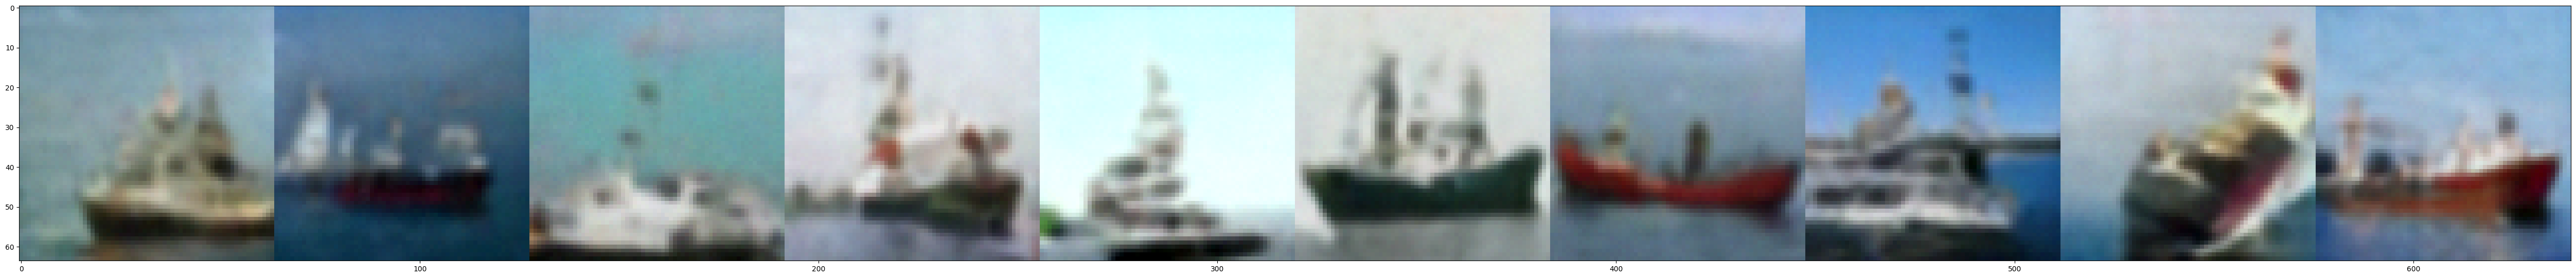

In [22]:
y = torch.Tensor([tag_dict[input]] * n).long().to(device)
x = diffusion.sample(model, n, y, cfg_scale=3)

plt.figure(figsize=(64, 64))
plt.imshow(torch.cat([
    torch.cat([i for i in x.cpu()], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()